# KING COUNTY HOUSING PREDICTIVE MODEL

### This notebook is designed to build a predictive model for the prices of houses in King County

## ETL

In [1]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_e62b6c1bb76c4710b1d1cc5aeab9a929 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='9ZymKSD_6E0Aw3YRO1fn1RBF95BmxW_zKvIslTE4CC4g',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_e62b6c1bb76c4710b1d1cc5aeab9a929.get_object(Bucket='databel-donotdelete-pr-d4qsbyzwywn9lq',Key='kc_house_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
df_kc = df_data_1

### Importing packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style = 'ticks')
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

### Transforming and Exploring data

In [4]:
df_kc['age'] = 2015 - df_kc['yr_built']

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

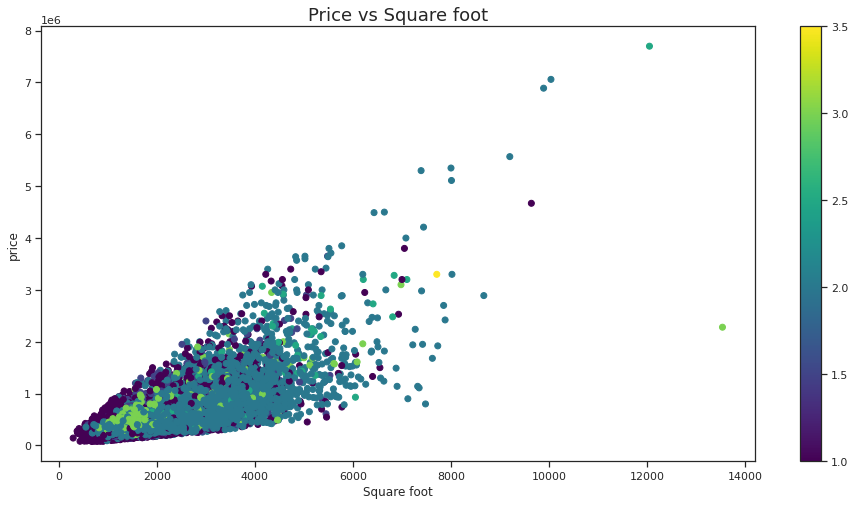

In [6]:
plt.figure(figsize = (16,8))
plt.scatter(x = 'sqft_living', y = 'price', data = df_kc, c = 'floors', cmap = 'viridis')
plt.xlabel("Square foot", fontsize = 12)
plt.ylabel("price", fontsize = 12)
plt.title("Price vs Square foot", fontsize = 18)
plt.colorbar()
plt.show();

In [7]:
df_kc_new = df_kc[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'age', 'sqft_living15', 'sqft_lot15']]

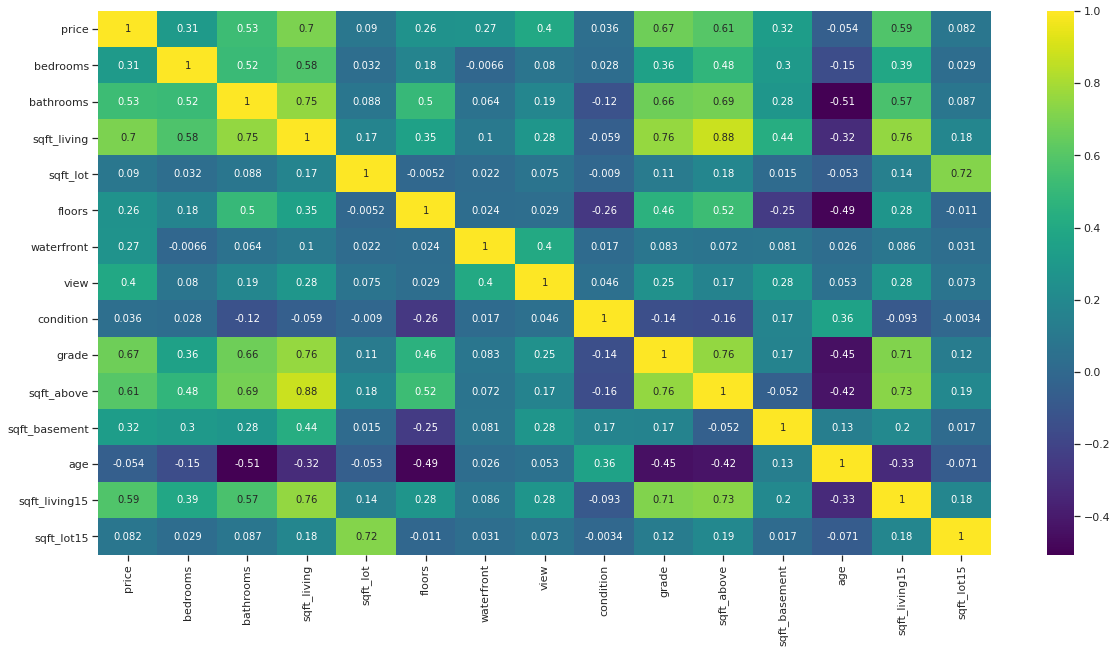

In [8]:
cor = df_kc_new.corr()
plt.figure(figsize = (20, 10))
sns.heatmap(cor, annot = True, cmap = 'viridis');

In [9]:
df_kc_new.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,age,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,60,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,64,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,82,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,50,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,28,1800,7503


In [10]:
df_kc_new['view'].unique()

array([0, 3, 4, 2, 1])

In [11]:
df_kc_new['waterfront'].unique()

array([0, 1])

In [35]:
kk = df_kc_new[df_kc_new["price"] == max(df_kc_new["price"])]
kk

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,age,sqft_living15,sqft_lot15
7252,7700000.0,6,8.0,12050,27600,2.5,0,3,4,13,8570,3480,105,3940,8800


In [36]:
kk['price']

7252    7700000.0
Name: price, dtype: float64

### Splitting the data

In [12]:
df_kc_x = df_kc_new.iloc[:, 1:]
df_kc_y = df_kc_new.iloc[:, 0]

In [13]:
kc_xtrain, kc_xtest, kc_ytrain, kc_ytest = train_test_split(df_kc_x, df_kc_y, train_size = 0.8, random_state = 69)

### Training the data

In [14]:
from sklearn.compose import ColumnTransformer

In [15]:
std = StandardScaler()

In [16]:
clean_row = ColumnTransformer([("scale", std, ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'])])

In [17]:
poly = PolynomialFeatures()
rfe_cv = RFECV(Lasso(alpha = 0.1), cv = 5)
lin_reg = LinearRegression()
random_reg = RandomForestRegressor()

In [18]:
full_pipeline = Pipeline([##("cl", std), 
    ("Recurse", rfe_cv), 
    ("reg", random_reg)])

In [19]:
##pca = PCA(n_components = 0.95)
##pca_x = pca.fit_transform(kc_xtrain)

In [20]:
##pca_pipeline = Pipeline([("reg", random_reg)])

In [21]:
param_grid = [{'reg__n_estimators': np.arange(1,20), 'reg__max_features': np.arange(1,5)}]
gridsearch = GridSearchCV(full_pipeline, param_grid, cv = 5, scoring = 'r2')

In [23]:
gridsearch.fit(kc_xtrain, kc_ytrain);

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57190573905903.16, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54744055008528.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56121147915912.34, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57045857832740.53, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57359638469153.84, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55013307991821.94, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55332612045067.31, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56464024453947.97, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56797489116259.09, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57685493967531.31, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55741059198954.03, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conve

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57587965231629.97, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283595552412879.1, tolerance: 178765662188.85965
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220587446949402.94, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55942981184780.09, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230592172401395.8, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58370713932147.16, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218378855007986.5, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228277110852870.53, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57459120745832.875, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226095930694675.28, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did no

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54698392499339.78, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277093707308664.9, tolerance: 174980738787.14127
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220094796893952.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54744055008528.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57045857832740.53, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56121147915912.34, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57359638469153.84, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55332612045067.31, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55013307991821.94, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56464024453947.97, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56693247884534.25, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54096322292583.28, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55159897412247.59, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57777471774640.16, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55741059198954.03, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57079790727034.78, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conv

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55222938221538.09, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230592172401395.8, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220587446949402.94, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55942981184780.09, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228277110852870.53, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218378855007986.5, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54698392499339.78, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277093707308664.9, tolerance: 174980738787.14127
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226095930694675.28, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57040157730893.97, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220094796893952.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57190573905903.16, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56121147915912.34, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57359638469153.84, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55013307991821.94, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55332612045067.31, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56693247884534.25, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56464024453947.97, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54096322292583.28, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56797489116259.09, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57685493967531.31, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55159897412247.59, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57777471774640.16, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55741059198954.03, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conve

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57587965231629.97, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57079790727034.78, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283595552412879.1, tolerance: 178765662188.85965
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55222938221538.09, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230592172401395.8, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220587446949402.94, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55942981184780.09, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228277110852870.53, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58370713932147.16, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218378855007986.5, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54698392499339.78, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57459120745832.875, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226095930694675.28, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57040157730893.97, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277093707308664.9, tolerance: 174980738787.14127
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57190573905903.16, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220094796893952.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54744055008528.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57045857832740.53, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56121147915912.34, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57359638469153.84, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55332612045067.31, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55013307991821.94, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56464024453947.97, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56693247884534.25, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54096322292583.28, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56797489116259.09, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55159897412247.59, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57685493967531.31, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57777471774640.16, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55741059198954.03, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conve

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57587965231629.97, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57079790727034.78, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283595552412879.1, tolerance: 178765662188.85965
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220587446949402.94, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230592172401395.8, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58370713932147.16, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218378855007986.5, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228277110852870.53, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57459120745832.875, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226095930694675.28, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did no

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277093707308664.9, tolerance: 174980738787.14127
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57190573905903.16, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220094796893952.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54744055008528.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57045857832740.53, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55013307991821.94, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55332612045067.31, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56464024453947.97, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56693247884534.25, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54096322292583.28, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56797489116259.09, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57685493967531.31, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55159897412247.59, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57777471774640.16, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55741059198954.03, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57079790727034.78, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conv

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57587965231629.97, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55222938221538.09, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283595552412879.1, tolerance: 178765662188.85965
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220587446949402.94, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55942981184780.09, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230592172401395.8, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58370713932147.16, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218378855007986.5, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228277110852870.53, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57459120745832.875, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226095930694675.28, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did no

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54698392499339.78, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277093707308664.9, tolerance: 174980738787.14127
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57040157730893.97, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220094796893952.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54744055008528.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57045857832740.53, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55013307991821.94, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55332612045067.31, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56464024453947.97, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56693247884534.25, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54096322292583.28, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56797489116259.09, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57685493967531.31, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55159897412247.59, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57777471774640.16, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57079790727034.78, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283595552412879.1, tolerance: 178765662188.85965
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55222938221538.09, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230592172401395.8, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220587446949402.94, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55942981184780.09, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228277110852870.53, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218378855007986.5, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54698392499339.78, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277093707308664.9, tolerance: 174980738787.14127
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226095930694675.28, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57040157730893.97, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220094796893952.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57190573905903.16, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56121147915912.34, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57359638469153.84, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55013307991821.94, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55332612045067.31, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56693247884534.25, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56464024453947.97, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54096322292583.28, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56797489116259.09, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57685493967531.31, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55159897412247.59, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57777471774640.16, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55741059198954.03, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conve

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57587965231629.97, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57079790727034.78, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283595552412879.1, tolerance: 178765662188.85965
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55222938221538.09, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230592172401395.8, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220587446949402.94, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55942981184780.09, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228277110852870.53, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218378855007986.5, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54698392499339.78, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277093707308664.9, tolerance: 174980738787.14127
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226095930694675.28, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57040157730893.97, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220094796893952.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57190573905903.16, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56121147915912.34, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57359638469153.84, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55013307991821.94, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56693247884534.25, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54096322292583.28, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56797489116259.09, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55159897412247.59, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57685493967531.31, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57777471774640.16, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not c

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55741059198954.03, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conve

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57587965231629.97, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283595552412879.1, tolerance: 178765662188.85965
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220587446949402.94, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55942981184780.09, tolerance: 141597962749.4208
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230592172401395.8, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58370713932147.16, tolerance: 143461392175.0073
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218378855007986.5, tolerance: 135746152896.94705
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228277110852870.53, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57459120745832.875, tolerance: 142289507010.10147
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226095930694675.28, tolerance: 142199001524.43637
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did no

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277093707308664.9, tolerance: 174980738787.14127
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57190573905903.16, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220094796893952.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54744055008528.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57045857832740.53, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225211732622528.47, tolerance: 140760308698.44046
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56121147915912.34, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279488088718670.66, tolerance: 175616067089.62692
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218781342822946.06, tolerance: 138661433690.37708
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219119902340398.3, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55332612045067.31, tolerance: 136264231771.79486
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220214416604349.2, tolerance: 140481073562.4514
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225919930985970.66, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56464024453947.97, tolerance: 139344922899.80402
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216138861177684.25, tolerance: 135763233526.37071
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221435398547674.6, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56937496306949.72, tolerance: 144750805827.98074
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226761974687328.2, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56797489116259.09, tolerance: 139556099680.66968
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220637251266387.22, tolerance: 137357797858.98915
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228687669036234.9, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57685493967531.31, tolerance: 143919649357.9679
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229179726910978.38, tolerance: 143717461942.67313
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277567580929724.0, tolerance: 172673962134.30923
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217941596638715.62, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56168032894705.53, tolerance: 140958993426.9008
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not co

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222833493697090.5, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55741059198954.03, tolerance: 139214304633.338
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226366910252232.44, tolerance: 143443112613.6755
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conve

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225502885964475.16, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57587965231629.97, tolerance: 141654272851.17566
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216323108750672.8, tolerance: 138087199814.39243
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

In [24]:
new_model = gridsearch.best_estimator_

In [25]:
new_model.fit(kc_xtrain, kc_ytrain)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277240401256889.28, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70960871551701.38, tolerance: 175809143503.05908
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283595552412879.1, tolerance: 178765662188.85965
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

Pipeline(steps=[('Recurse', RFECV(cv=5, estimator=Lasso(alpha=0.1))),
                ('reg',
                 RandomForestRegressor(max_features=4, n_estimators=15))])

In [26]:
y_cv_pred = cross_val_predict(new_model, kc_xtrain, kc_ytrain, cv = 5)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221485257429274.5, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57190573905903.16, tolerance: 142577450436.2941
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223009697000325.6, tolerance: 143137509124.87137
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not con

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54744055008528.94, tolerance: 136073262324.86505
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222882327713464.94, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56121147915912.34, tolerance: 140285998845.37668
  positive)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not 

In [27]:
kc_pred = new_model.predict(kc_xtest)

In [28]:
r2_score(kc_ytest, kc_pred)

0.7566593645604105